In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms
from torchvision.utils import make_grid 

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt


In [39]:
transform= transforms.ToTensor()
train_data= datasets.MNIST(root='../Data',train=True,download= True,transform=transform)

In [40]:
test_data= datasets.MNIST(root='../Data',train=True,download= True,transform=transform)

In [41]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [42]:
test_data


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

# deciding Batch sizes

In [43]:
trainloader= DataLoader(train_data,batch_size=10,shuffle=True)
testloader=DataLoader(test_data,batch_size=10,shuffle=True)

# breaking down cnn model(just for understanding)

In [44]:
conv1= nn.Conv2d(1,6,3,1)   #1 input since grayscale, 6 outputs for feature xtraction or 6 filters , 3 for 3*3 filter, 1 Stride
#--->6 filters-->pooling--->conv2

conv2= nn.Conv2d(6,16,3,1) #6 inputs from conv1, 16 filters ,3*3, 1 stride

# grabbing the first mnist record

In [45]:
for i,(X_train,y_train) in enumerate(train_data):
    break

In [46]:
x= X_train.view(1,1,28,28)  #--> 4d batch(batch of 1 image)

In [47]:
x=F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

# now into pooling layer


In [48]:
x=F.max_pool2d(x,2,2) 
x.shape

torch.Size([1, 6, 13, 13])

# now into conv2

In [49]:
x= F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [50]:
x= F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

# now flattening for a fc 

In [51]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

# actual implementation
Now to define the class model

In [52]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(1,6,3,1)
        self.conv2= nn.Conv2d(6,16,3,1)
        self.fc1= nn.Linear(5*5*16,120)
        self.fc2= nn.Linear(120,84)
        self.fc3= nn.Linear(84,10)
    
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*5*5)
        X= F.relu(self.fc1(X))
        X= F.relu(self.fc2(X))
        X= self.fc3(X)
        return F.log_softmax(X,dim=1)

In [53]:
torch.manual_seed(42)
model= ConvNet()
model

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# to check if parameters are reduced in cnn when compared to ann

In [54]:
for param in model.parameters():
    print(param.numel())
#much less than ann's 100,000 params

54
6
864
16
48000
120
10080
84
840
10


In [55]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.001)

In [56]:
import time
starttime= time.time()

#TRACKERS
epochs=5
trainlosses=[]
testlosses=[]
traincorrect=[]
testcorrect=[]

#FOR LOOP EPOCHS
for i in range(epochs):
    trncorr=0
    tstcorr=0
    #TRAIN
    for b,(X_train,y_train) in enumerate(trainloader):
        b+=1
        
        y_pred=model(X_train)  #no flattening!!
        loss= criterion(y_pred,y_train)
        predicted= torch.max(y_pred.data,1)[1]
        batchcorr= (predicted==y_train).sum()
        trncorr+=batchcorr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 ==0:
            print(f"epoch {i} batch {b} loss {loss.item()}")
    trainlosses.append(loss)
    traincorrect.append(trncorr)
#TEST
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(testloader):
            yval= model(X_test)
            predicted=torch.max(yval.data,1)[1]
            tstcorr+=(predicted==y_test).sum()
    loss= criterion(yval,y_test)
    testlosses.append(loss)
    testcorrect.append(tstcorr)
         

currenttime= time.time()
total =currenttime- starttime
print(f"Train time {total/60} mins")

epoch 0 batch 600 loss 0.21157124638557434
epoch 0 batch 1200 loss 0.579678475856781
epoch 0 batch 1800 loss 0.05560563877224922
epoch 0 batch 2400 loss 0.0341942124068737
epoch 0 batch 3000 loss 0.010335903614759445
epoch 0 batch 3600 loss 0.005747481714934111
epoch 0 batch 4200 loss 0.053997285664081573
epoch 0 batch 4800 loss 0.0029320730827748775
epoch 0 batch 5400 loss 0.00047731475206092
epoch 0 batch 6000 loss 0.005763170309364796
epoch 1 batch 600 loss 0.14184677600860596
epoch 1 batch 1200 loss 0.003080874215811491
epoch 1 batch 1800 loss 0.02287227287888527
epoch 1 batch 2400 loss 0.023083675652742386
epoch 1 batch 3000 loss 0.006155517417937517
epoch 1 batch 3600 loss 0.02127629891037941
epoch 1 batch 4200 loss 0.00015270806034095585
epoch 1 batch 4800 loss 0.0016358854481950402
epoch 1 batch 5400 loss 0.47612157464027405
epoch 1 batch 6000 loss 0.2730788290500641
epoch 2 batch 600 loss 0.0048591666854918
epoch 2 batch 1200 loss 0.0010632217163220048
epoch 2 batch 1800 loss 

# evaluating model

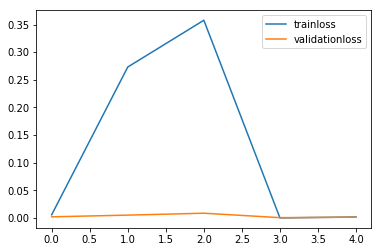

In [58]:
plt.plot(trainlosses,label= 'trainloss')
plt.plot(testlosses,label='validationloss')
plt.legend()

In [60]:
#Evaluate Test Data
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 59592/60000 =  99.320%


In [62]:
#Display the confusion matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 988    0    0    0    0    0    0    0    0    1]
 [   0 1060    1    0    1    0    0    0    0    0]
 [   1    0  984    1    0    0    0    0    0    0]
 [   0    0    0 1020    0    0    0    0    1    0]
 [   0    0    1    0  975    0    0    0    0    5]
 [   1    0    0    4    0  912    0    0    1    2]
 [   0    2    0    0    1    1  967    0    1    0]
 [   1    2    3    2    1    0    0 1090    3    2]
 [   0    0    1    2    0    2    0    0  995    0]
 [   0    0    0    1    5    0    0    0    8  951]]
